In [238]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import json
import matplotlib.dates as mdates
import codecs
import scipy.signal
import pprint
from scipy.cluster.vq import kmeans2
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D

In [239]:
from collections import defaultdict

In [240]:
orig_json = None
with codecs.open('D:\\Research\\kevin.json',encoding='utf-8') as f:
    orig_json = json.loads(f.read())

In [241]:
lifeLog = orig_json['lifeLog']
print(lifeLog.keys())

dict_keys(['0410_2018', '0411_2018', '0414_2018', '0415_2018', '0416_2018', '0417_2018', '0501_2018', '0502_2018', '0503_2018', '0504_2018', '0505_2018', '0506_2018', '0507_2018', '0508_2018', '0509_2018', '0510_2018', '0511_2018', '0512_2018', '0513_2018', '0514_2018'])


In [242]:
#print(lifeLog['0117_2018']['mobile'].keys())
#sample = ['0116_2018', '0117_2018', '1214_2017']
#json_sample = {key:value for key,value in lifeLog.items() if key in sample}
#json_sample = {key:value for key,value in lifeLog.items()}
activities_list = []

#date_index = list(lifeLog.keys()).index('0316_2018')
date_index = list(lifeLog.keys()).index('0415_2018')

for i in list(lifeLog.keys())[date_index:date_index+2]:
    if type(lifeLog[i]['mobile']) == list:
        activities_list += [j for j in lifeLog[i]['mobile'] if j]
    else:
        activities_list += [j for j in lifeLog[i]['mobile'].values()]
#print(json.dumps(json_sample))
#with open('json_sample','w+') as f:
#    f.write(json.dumps(json_sample))

In [243]:
print(lifeLog.keys())

dict_keys(['0410_2018', '0411_2018', '0414_2018', '0415_2018', '0416_2018', '0417_2018', '0501_2018', '0502_2018', '0503_2018', '0504_2018', '0505_2018', '0506_2018', '0507_2018', '0508_2018', '0509_2018', '0510_2018', '0511_2018', '0512_2018', '0513_2018', '0514_2018'])


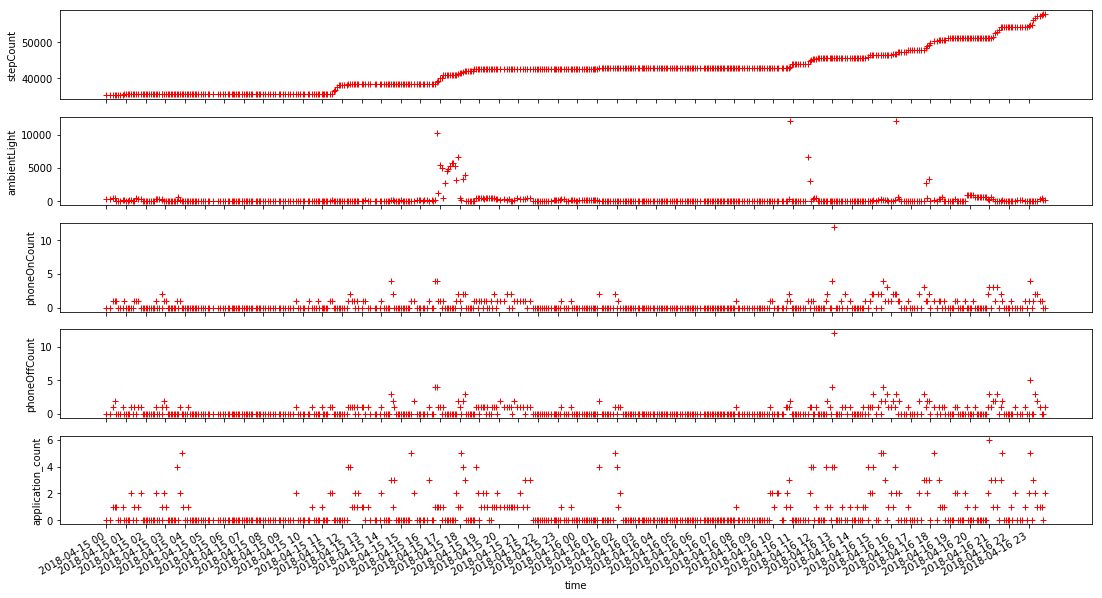

In [244]:
activities_list.sort(key=lambda x: x['time']['timeStamp'])
ys = ['stepCount','ambientLight','phoneOnCount','phoneOffCount']
fig, axarr = plt.subplots(len(ys)+1, sharex=True)
fig.autofmt_xdate()
fig.set_size_inches(18.5, 10.5)
plt.xlabel('time')
x_data = [datetime.datetime.fromtimestamp(i['time']['timeStamp']/1000) for i in activities_list]
dt64 = [np.datetime64(dt) for dt in x_data]
plt.xticks([i.tolist() for i in np.arange(min(dt64), max(dt64)+1,datetime.timedelta(days=3))])

for index,i in enumerate(ys):
    y_data = np.array([j[i] for j in activities_list])
    #y_data = scipy.signal.savgol_filter(y_data, 5, 1)
    axarr[index].set_ylabel(i)
    axarr[index].plot(x_data,y_data,'r+')
y_data = np.array([j['application']['count'] for j in activities_list])
#y_data = scipy.signal.savgol_filter(y_data, 5, 1)
axarr[index+1].set_ylabel('application_count')


axarr[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H'))
axarr[0].xaxis.set_ticks([i.tolist() for i in np.arange(min(dt64), max(dt64)+1,datetime.timedelta(hours=1))])

axarr[index+1].plot(x_data,y_data,'r+')
plt.show()

In [245]:
#constants for how important each feature is
AMBIENT_LIGHT = 0.1
STEP_COUNT = 0.3
APP = 0.2
merged = []

ambient_light = []
step_deriv = []
hour = []
app_count = []
phone_on = []
phone_off = []

prev_steps = 0
prev_light = 0
#prev_app_num = 0;
for i in list(lifeLog.values()):#[date_index:date_index+2]:
    for j in i['mobile']:
        if j == None:
            continue
        if type(j) == str:
#             x = {
#                 'time': datetime.datetime(int(i['mobile'][j]['time']['dateFormat'][:4]),
#                                           int(i['mobile'][j]['time']['dateFormat'][4:6]),
#                                           int(i['mobile'][j]['time']['dateFormat'][6:8]),
#                                           hour=int(i['mobile'][j]['time']['dateFormat'][9:11]),
#                                           minute=int(i['mobile'][j]['time']['dateFormat'][12:14])),
#                 'timeWindow': i['mobile'][j]['time']['timeWindow'],
#                 'ambientLight': i['mobile'][j]['ambientLight'],
#                 'stepCountDerivative':(i['mobile'][j]['stepCount'] - prev_steps),
#                 'hour': int(i['mobile'][j]['time']['dateFormat'][9:11]),
#                 'appCount':i['mobile'][j]['application']['count'],
#                 'phoneOnCount':i['mobile'][j]['phoneOnCount'],
#                 'phoneOffCount':i['mobile'][j]['phoneOffCount']
#             }
            if 'application' in i['mobile'][j]:
                ambient_light.append(i['mobile'][j]['ambientLight'])
                step_deriv.append(i['mobile'][j]['stepCount'] - prev_steps)
                hour.append(int(i['mobile'][j]['time']['dateFormat'][9:11])*1/6)
                app_count.append(i['mobile'][j]['application']['count'])
                phone_on.append(i['mobile'][j]['phoneOnCount'])
                phone_off.append(i['mobile'][j]['phoneOffCount'])
            
            
                prev_light = i['mobile'][j]['ambientLight']
                prev_steps = i['mobile'][j]['stepCount']
        else:
            if 'application' in j:
                ambient_light.append(j['ambientLight'])
                step_deriv.append(j['stepCount'] - prev_steps)
                #hour is made less important
                hour.append(int(j['time']['dateFormat'][9:11])*1/6)
                #app count is made more important here for scaling
                app_count.append(j['application']['count']*20)
                phone_on.append(j['phoneOnCount'])
                phone_off.append(j['phoneOffCount'])
            
            
                prev_light = j['ambientLight']
                prev_steps = j['stepCount']
            #TODO            

filtered_app_count = scipy.signal.savgol_filter(app_count, 5, 1)
filtered_ambient_light = scipy.signal.savgol_filter(ambient_light,11,1)

#merged = np.column_stack((ambient_light,step_deriv,hour,filtered_app_count,phone_on,phone_off))
# Window of 5 time slots
# merged = np.column_stack((ambient_light[:-5],ambient_light[1:-4],ambient_light[2:-3],ambient_light[3:-2],ambient_light[4:-1],
#                           hour[:-5],hour[1:-4],hour[2:-3],hour[3:-2],hour[4:-1],
#                           filtered_app_count[:-5],filtered_app_count[1:-4],filtered_app_count[2:-3],filtered_app_count[3:-2],filtered_app_count[4:-1]))

# for a window of size 3 (15 minutes)
WINDOW_SIZE=5
average_app_count = [sum(filtered_app_count[i+j] for j in range(WINDOW_SIZE))/WINDOW_SIZE for i in range(len(filtered_app_count)-WINDOW_SIZE)]
average_ambient_light = [sum(ambient_light[i+j] for j in range(WINDOW_SIZE))/WINDOW_SIZE for i in range(len(filtered_ambient_light)-WINDOW_SIZE)]
average_step_deriv = [sum(step_deriv[i+j] for j in range(WINDOW_SIZE))/WINDOW_SIZE for i in range(len(step_deriv)-WINDOW_SIZE)]
max_app_count = [max(filtered_app_count[i+j] for j in range(WINDOW_SIZE)) for i in range(len(filtered_app_count)-WINDOW_SIZE)]
max_ambient_light = [max(ambient_light[i+j] for j in range(WINDOW_SIZE)) for i in range(len(filtered_ambient_light)-WINDOW_SIZE)]

merged = np.column_stack((average_ambient_light,
                          hour[int(WINDOW_SIZE/2):-(WINDOW_SIZE-int(WINDOW_SIZE/2))],
                          average_app_count,
                          max_app_count,
                          max_ambient_light
                        ))

In [246]:
print(merged)

[[  215.91598989     2.16666667     1.98           2.8          456.875     ]
 [  275.66259909     2.16666667     1.78           2.1          755.60804598]
 [  288.07564567     2.16666667     1.72           1.8          755.60804598]
 ..., 
 [ 1175.5448721      2.33333333     5.6           12.          1183.97333333]
 [ 1175.34857053     2.33333333     5.6           12.          1183.97333333]
 [ 1172.33821759     2.33333333     8.            16.          1178.47826087]]


In [247]:
print(len(merged))

3675


In [248]:
merged_scaled = preprocessing.scale(merged)
# min_max_scaler = preprocessing.MinMaxScaler()
# merged_scaled = min_max_scaler.fit_transform(merged)

In [249]:
#pprint.pprint(merged_scaled)

In [250]:
codebook, labels = kmeans2(merged_scaled,3)

In [251]:
print(codebook)
print(labels)
print(len(labels))

[[ -0.11627954  -0.09493691  -0.4992341   -0.50250023  -0.12334606]
 [ 11.34659658   0.41133409   1.97871519   1.7442016   11.35222308]
 [  0.08728652   0.25323135   1.33542811   1.34925137   0.1066492 ]]
[0 0 0 ..., 0 0 0]
3675


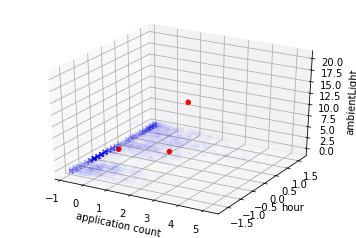

In [252]:
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(merged_scaled[:,2],merged_scaled[:,1],zs=merged_scaled[:,0],c='b',marker='x',alpha=0.01)
ax.scatter(codebook[:,2],codebook[:,1],zs=codebook[:,0],c='r',marker='o',alpha=1)
ax.set_ylabel('hour')
ax.set_xlabel('application count')
ax.set_zlabel('ambientLight')
plt.show()

In [253]:
sleep_centroid = 0
lowest_appcount = 100
for i,observed in enumerate(codebook):
    if observed[2] < lowest_appcount:
        sleep_centroid = i
        lowest_appcount = observed[2]
print(sleep_centroid)

0


In [254]:
ind = 0 #This will always be between 0 and len(labels) aka the number of data points inputted
final_sleep_array = []

for i in list(lifeLog.values()):#[date_index:date_index+2]:
    for j in i['mobile']:
        if ind == len(labels):
            break
            #since I'm using windows, it has to be that the iteration ends WINDOW_SIZE early
        
        if j == None:
            continue
        if type(j) == str:
            if 'application' in i['mobile'][j]:
                if labels[ind] == sleep_centroid:
                    final_sleep_array.append({
                        'time': datetime.datetime(int(i['mobile'][j]['time']['dateFormat'][:4]),
                                              int(i['mobile'][j]['time']['dateFormat'][4:6]),
                                              int(i['mobile'][j]['time']['dateFormat'][6:8]),
                                              hour=int(i['mobile'][j]['time']['dateFormat'][9:11]),
                                              minute=int(i['mobile'][j]['time']['dateFormat'][12:14])),
                        'timeWindow': i['mobile'][j]['time']['timeWindow']
                    })
                else:
                    final_sleep_array.append({})
                ind += 1;
        else:
            if 'application' in j:
                if labels[ind] == sleep_centroid:
                    final_sleep_array.append({
                        'time': datetime.datetime(int(j['time']['dateFormat'][:4]),
                                              int(j['time']['dateFormat'][4:6]),
                                              int(j['time']['dateFormat'][6:8]),
                                              hour=int(j['time']['dateFormat'][9:11]),
                                              minute=int(j['time']['dateFormat'][12:14])),
                        'timeWindow': j['time']['timeWindow']
                    })
                else:
                    final_sleep_array.append({})
                ind += 1;


In [255]:
sleep_history = []
ind = 0
sleep_segment = []
print(len(final_sleep_array))
while ind < len(labels):
    if final_sleep_array[ind] != {}:
        sleep_segment.append(final_sleep_array[ind])
    else:
        if len(sleep_segment) >= 24:
            #TODO increase the end time based on how large the observation window is
             sleep_history.append({
                    'startTimeWindow':sleep_segment[0]['timeWindow'],
                    'endTimeWindow': sleep_segment[-1]['timeWindow'],
                    'startTime': sleep_segment[0]['time'],
                    'endTime': sleep_segment[-1]['time'],
                    'minutesAsSleep': (sleep_segment[-1]['time'] - sleep_segment[0]['time']).total_seconds()/60
        })
        sleep_segment = []
    ind += 1

3675


In [256]:
#pprint.pprint([i['startTime'] for i in sleep_history])

In [257]:
agg_sleeps = []
for i in orig_json['lifeLog'].values():
    try:
        end_time =  datetime.datetime(int(i['wearable']['daily']['sleep'][0]['endTime'][:4]),
                                      int(i['wearable']['daily']['sleep'][0]['endTime'][5:7]),
                                      int(i['wearable']['daily']['sleep'][0]['endTime'][8:10]),
                                      hour=int(i['wearable']['daily']['sleep'][0]['endTime'][11:13]),
                                      minute=int(i['wearable']['daily']['sleep'][0]['endTime'][14:16]))
        start_time =  datetime.datetime(int(i['wearable']['daily']['sleep'][0]['startTime'][:4]),
                                      int(i['wearable']['daily']['sleep'][0]['startTime'][5:7]),
                                      int(i['wearable']['daily']['sleep'][0]['startTime'][8:10]),
                                      hour=int(i['wearable']['daily']['sleep'][0]['startTime'][11:13]),
                                      minute=int(i['wearable']['daily']['sleep'][0]['startTime'][14:16]))
        
        start_dif_info = min([(abs(start_time-j['startTime']),(start_time-j['startTime']),ind) for ind,j in enumerate(sleep_history)])
        end_dif_info = min([(abs(end_time-j['endTime']),(end_time-j['endTime']),ind) for ind,j in enumerate(sleep_history)])
        differences = {
            "startTimeDifference": start_dif_info[1].total_seconds()/60,
            "endTimeDifference": end_dif_info[1].total_seconds()/60,
            "fitBitStart": start_time,
            "windowStart": sleep_history[end_dif_info[2]]['startTime'],
            "fitBitEnd": end_time,
            "windowEnd": sleep_history[end_dif_info[2]]['endTime']
        }
        
        agg_sleeps.append(differences)
    except KeyError as e:
        #print(e)
        pass
#pprint.pprint(agg_sleeps)

In [258]:
start_average = [abs(i['startTimeDifference']) for i in agg_sleeps if abs(i['startTimeDifference'])]
print("Average absolute value of start time error (m) excluding impossible numbers from missing data:",sum(start_average)/len(start_average))
end_average = [abs(i['endTimeDifference']) for i in agg_sleeps if abs(i['endTimeDifference'])]
print("Average absolute value of end time error (m) excluding impossible numbers from missing data:",sum(end_average)/len(end_average))
duration_average = [abs((i['windowEnd'] - i['windowStart']) - (i['fitBitEnd'] - i['fitBitStart'])).total_seconds()/60 for i in agg_sleeps]
print("Average absolute value of duration error (m) excluding impossible numbers from missing data:",sum(duration_average)/len(duration_average))


Average absolute value of start time error (m) excluding impossible numbers from missing data: 166.75
Average absolute value of end time error (m) excluding impossible numbers from missing data: 262.5
Average absolute value of duration error (m) excluding impossible numbers from missing data: 417.25


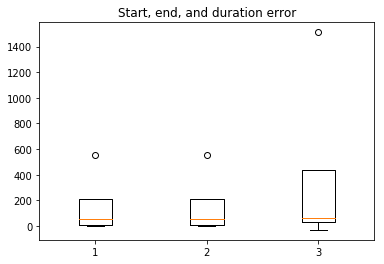

In [259]:
start_error = [i['startTimeDifference'] for i in agg_sleeps]
end_error = [i['startTimeDifference'] for i in agg_sleeps]
duration_error = duration_average = [((i['windowEnd'] - i['windowStart']) - (i['fitBitEnd'] - i['fitBitStart'])).total_seconds()/60 for i in agg_sleeps]

plt.figure(3)
plt.boxplot([start_error,end_error,duration_error])
plt.title('Start, end, and duration error')
plt.show()



In [260]:
def sub_min_0(a,b):
    if (a-b).seconds > 0 and (a-b).days >=0:
        return (a-b).seconds 
    return 0

In [261]:
for i in agg_sleeps:
    TP = (min(i['fitBitEnd'],i['windowEnd']) - max(i['fitBitStart'], i['windowStart'])).seconds
    #print(TP)
    FP = sub_min_0(i['fitBitStart'],i['windowStart']) + sub_min_0(i['windowEnd'],i['fitBitEnd'])
    #print(sub_min_0(i['fitBitStart'],i['windowStart']), sub_min_0(i['windowEnd'],i['fitBitEnd']))
    FN = sub_min_0(i['fitBitEnd'],i['windowEnd']) + sub_min_0(i['windowStart'],i['fitBitStart'])
    i['precision'] = TP / (TP + FP)
    i['recall'] = TP / (TP+FN)
    i['F_Score'] = 2*i['precision']*i['recall'] / (i['recall']+i['precision'])

In [262]:
#pprint.pprint(agg_sleeps)

In [263]:
print("average precision:", np.mean([i['precision'] for i in agg_sleeps]))
print("average recall:", np.mean([i['recall'] for i in agg_sleeps]))
print("average F-Score:", np.mean([i['F_Score'] for i in agg_sleeps]))

average precision: 0.715250110155
average recall: 0.964421039765
average F-Score: 0.767344644504
